In [1]:
using Distributions
using Plots
pyplot()

Plots.PyPlotBackend()

In [39]:
function transform_svm_primal(X, y, C = .5)
    #The variable becomes the concatenation of w and z here.
    d = size(X,2)
    n = size(X,1)
    Q = zeros(d+n, d+n)
    Q[1:d, 1:d] = eye(d)
    p = zeros(d+n)
    p[d+1:d+n] = [C for _ in 1:n]
    Y = diagm(y)
    A = zeros(2*n, d+n)
    A[1:n,1:d] = - Y*X
    A[1:n, d+1:d+n] = -eye(n)
    A[n+1:2*n, d+1:d+n] = -eye(n)
    b = -ones(2*n)
    b[n+1:2*n] = zeros(n)
    return Q, p, A, b
end


function transform_svm_dual(X, y, C = .5)
    #Here, we keep lambda as the variable. We need to make A bigger to account for the 2 inequalities on lambda
    d = size(X,2)
    n = size(X,1)
    Q = diagm(y) * X * transpose(X) * diagm(y)
    p = ones(n)
    A = zeros(2*n, n)
    b = zeros(2*n)
    A[1:n, 1:n] = eye(n)
    A[n+1:2n, 1:n] = -eye(n)
    b[1:n] = C*ones(n)
    return Q, p, A, b
end


function generate_data(n1, n2, mean1 = -3*ones(2), mean2=3*ones(2), var1=ones(2), var2=ones(2))
    # Returns 2 clouds of labelled Gaussian data of dim 2 with different moments
    model1 = MvNormal(mean1, var1)
    model2 = MvNormal(mean2, var2)
    samples1 = rand(model1, n1)
    samples2 = rand(model2, n2)
    X = [transpose(samples1); transpose(samples2)]
    X = hcat(X, ones(n1+n2))
    y = ones(size(X,1))
    y[n1+1:n1+n2]= -1*ones(n2)
    return X, y
end


function backtracking(x, t, dx, f, nabla)
    alpha = .45 
    beta = .9
    res = 1
    max_iterations = 10
    while minimum(x + res*dx) < 10^(-3.)
        res *= beta
    end
    k= 0
    val = f(x,t)
    next_val = f(x+res*dx, t)
    while  next_val > (val + alpha * (res*transpose(nabla)*dx)[1])
        if k > max_iterations
            break
        end
        k+=1
        res *= beta
        next_val = f(x+res*dx,t)
    end
    return res
end

function Newton(t, x, f, grad, hess)
    nabla = grad(x, t)
    invHess = inv(hess(x,t))
    dx = - invHess * nabla
    lam2 = - (transpose(dx) * nabla)[1]
    backtrack_t = backtracking(x, t, dx, f, nabla)
    x_nt = x + backtrack_t * dx
    return x_nt, lam2/2
end

function centering_step(Q, p, A, b, x, t=1, tol=10^(-3.))
    function phi(u)
        return 1/2 * (transpose(u) * Q * u + transpose(p)*u)[1]
    end
    function f(u,v)
        return (v*phi(u) - sum([log(b[i] - A[i,:]* u) for i in size(A, 1)]))[1]
    end
    function grad(u,v)
        return v * (Q * u + p) + sum([transpose(A[i,:])/(b[i] - A[i,:] * u)[1] for i in 1:size(A,1)])
    end
    function hess(u,v)
        return v * Q - sum([transpose(A[i,:])*A[i,:]/(b[i] - A[i,:] * u)[1]^2. for i in size(A,1)])
    end
    x_sequence = []
    gaps = []
    obj_vals = []
    gap = Inf
    j = 0
    max_iterations = 20
    while (gap > tol)  
        j += 1
        if (j > max_iterations)
            break
        end
        x_new, gap = Newton(t, x, f, grad, hess)
        x = copy(x_new)
        push!(x_sequence, x)
        push!(obj_vals, f(x,t))
    end
    return x_sequence
end

function barr_method(Q, p, A, b, x_0, mu, tol=10^(-3.))
    x_sol = copy(x_0)
    m = size(x_0, 1)
    t = .5
    global gaps
    gaps = []
    while m/t > tol   
        global x_seq
        x_seq = centering_step(Q, p, A, b, x_sol, t, tol)
        x_sol = x_seq[end]
        t = mu * t
    end
    return x_sol, x_seq
end


function SVM_primal(X, y, C = .5)
    Q, p, A, b = transform_svm_primal(X, y, C)
    function phi(u)
        return 1/2 * (transpose(u) * Q * u + transpose(p)*u)[1]
    end
    mu = 15
    x_0 = C/2 * ones(size(A,2))
    x_star, xseq= barr_method(Q, p, A, b, x_0, mu)
    obj = phi(x_star)
    return x_star, xseq, obj
end


function SVM_dual(X, y, C=.5)
    Q, p, A, b = transform_svm_dual(X, y, C)
    function phi(u)
        return 1/2 * (transpose(u) * Q * u + transpose(p)*u)[1]
    end
    mu = 15
    x_0 = C/2 * ones(size(A,2))
    x_star, xseq= barr_method(Q, p, A, b, x_0, mu)
    obj = phi(x_star)
    w = sum([x_star[i]*y[i]*transpose(X[i,:]) for i in size(X,1)])
    return w
end

SVM_dual (generic function with 2 methods)

# Using the Dual

## Easy case : Classes well separated 

In [40]:
# srand(1234)
X,y = generate_data(20,20)
C = .5
w = SVM_dual(X,y,C);
y_pred = sign(X*w);


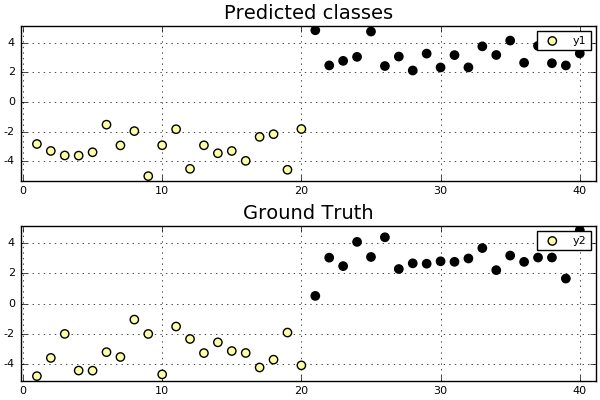

In [41]:
l = @layout([a;b])
scatter([X[:,1] X[:,2]], c=[y_pred y], layout=l, title=["Predicted classes" "Ground Truth"])

## Harder case: Classes overlapping 

In [42]:
# srand(1234)
X,y = generate_data(20,20, -3*ones(2), 3*ones(2), 6*eye(2), 6*eye(2))
C = .5
w = SVM_dual(X,y,C);
y_pred = sign(X*w);


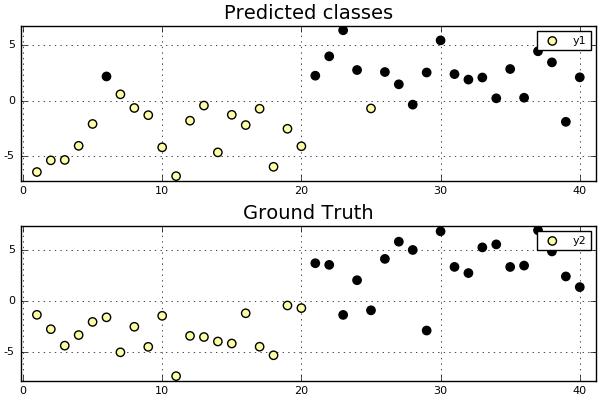

In [43]:
l = @layout([a;b])
scatter([X[:,1] X[:,2]], c=[y_pred y], layout=l, title=["Predicted classes" "Ground Truth"])